# Supervised Online Probabilistically Weighted Adaptive Tree Ensemble w/ Offline Post hoc Gradient Boosted Approximate Interpretability
Cameron J. Looney

## Overview

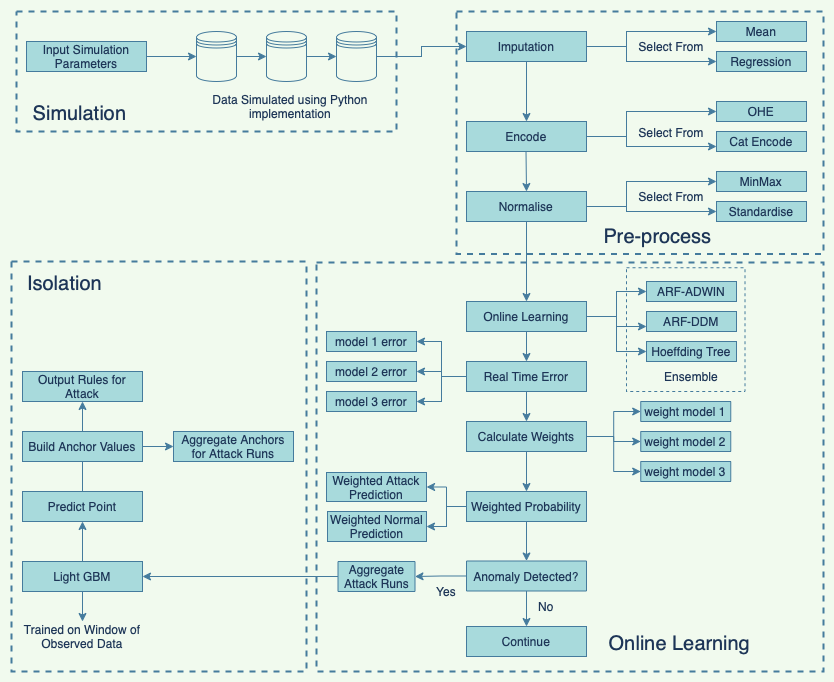

In [ ]:
from IPython.display import Image
Image(filename='/Users/cameronlooney/Downloads/Model Architecture-2.drawio.png') 

### Brief Pipeline Overview

#### Step 1: Simulation
The data is generated in Python using a class that sits on top of Fortran Code. Currently my class takes a dictionary of attacks and the range they occur. This allows the ability to produce attacks while maintaining the ground truth information and the ability to perform supervised learning. 

The simulation allows the ability to produce attacks of varying lengths, multi point attacks as well as normal operations data. 


#### Step 2: Pre-process
Standard preprocessing occurs here.

#### Step 3: Online Learning 
I have utilised the `riverml` [[package]("https://github.com/online-ml/river") , [paper]("https://arxiv.org/abs/2012.04740")] python package to transform this to an online task.

Rather than use a pre built ensemble or voting classifer I chose to implement my own, the reason for this was, alot of voting classifers dont take into account past performance, thus if one of the models is performing poorly, it will be treated the same as the top performing model, by designing a performance weighted ensemble approach I hope to reduce the impact of poorly performing classifiers while maximising the impact of classifers which are performing well. I will discuss this process and the model in general in more detail below. The model recieves the test data one index at a time, after the model has predicted the label then it will add to this its learned category, thus learning and adapting as new data is fed into the process. 

Attack runs are tracked and these are sent to the offline section of the model to interpret. Attacks runs are sequences of attack predictions that are uninterrupted. The logic here is that attacks occur across time rather than at a single index, thus if we produce runs of attack predictions we can quantify this as one attack. 

#### Step 4: Interpreting 
The attack runs are sent to the offline interpreter for post hoc analysis. The lightgbm [[paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)] model is trained during the online training phase, utilising the the Early Drift Detection Method [[paper](https://d1wqtxts1xzle7.cloudfront.net/48905428/Early_Drift_Detection_Method_20160917-1085-1m513qn-with-cover-page-v2.pdf?Expires=1668779805&Signature=fewwBUwYcvyX5vS13Sp~xSY1qeXI7jvFvSUnSoc09o9rfMWncyEFhmvjSgbLKSE4Cvq8SFJTE-KdCh2jziY9b1mQKB8hOGdH9Mis7VoZmLEwsBCP-GXLXLfcj0X2fLvlYduXM3R3HK-ERCz0r949H~BbfJY7CPjrGOshe6bPIEIE~OBsH8Cha3Uwy7im9VMFtfPl1Q~K6chRHPXUHu2P-EUbgbt871bIT5bfnKPxkU2X~K10X~32U1xsmjrlvIMSc0a-BHbExIGaFLg40pQYy0q2T9Ise78DXlbK8mka48q9NRe4QzZ7Hvwbreie1asgH461UyrSgzSaPNWrDOpruA__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)] to detect drift in the data and if drift is detected then the model is retrained on a recently observed subset of the data. We track the indices at which these retrains occur so we can reconstruct the model offline. Lightgbm was chosen due to its extremely fast training times. 

A run is passed to the interpretation model and the model uses the indices of the runs along with the indices at which the model was retrained to reproduce the lightgm model from online learning. Im not entirely certain if this approach is more effective than simply training on past data up to the start of the run specified by a window to look back too but I will experiment. The model then uses Anchors [[paper](https://homes.cs.washington.edu/~marcotcr/aaai18.pdf)] for the interpretation. Anchor values are calculated for each index in a run and whichever features are the most prevalent across the run are more likely to be under-attack directly or directly related to the feature under attack.

# Probabilistically Weighted Adaptive Tree Ensemble
1. Initialise the variables we need 
2. train each of the models in the ensemble using streamed training data
3. Stream the test data and for each point we predict it with each model individually
4. After the label has been predicted then each model learns that label and the associated feature values
5. The metric for each model is updated
6. The real time error for each model is calculated, the error usually is; <br>
$err_i = 1 - metric_i $
7. We then calculate the overall reciprocal error which is; <br>
$ ea = \sum_{i=1}^{3} \frac{1}{err_i + \epsilon}$

8. Calculate the weight for each model where weight is; <br>
$w_i =\frac{\frac{1}{err_i + \epsilon}}{ea} $
9. We then make our prediction whether the data is normal or an attack 

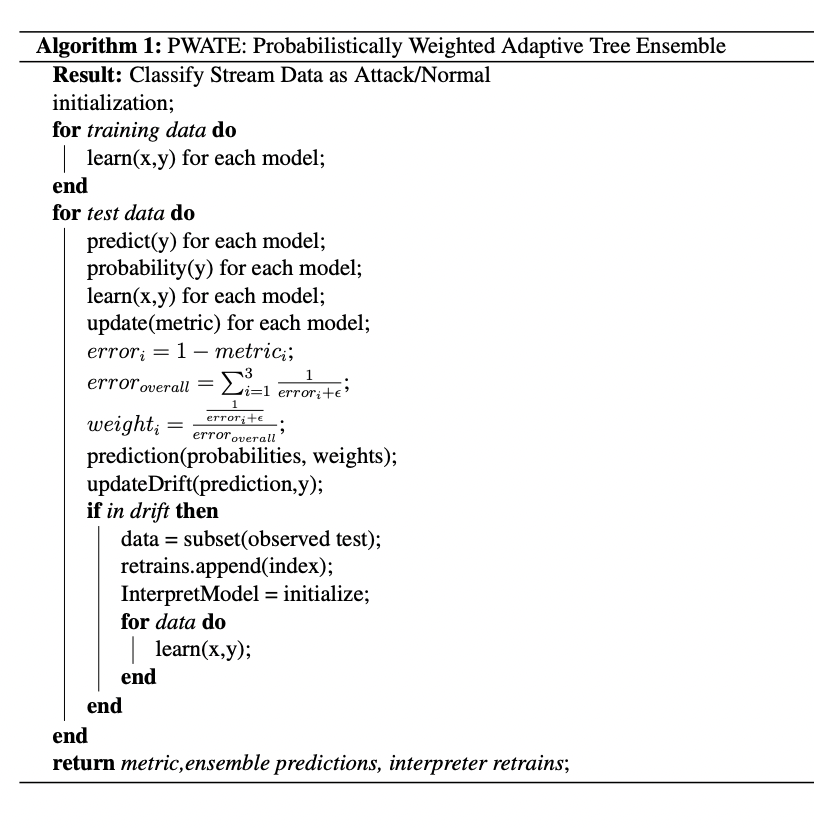

In [ ]:
Image(filename='/Users/cameronlooney/Desktop/Screenshot 2022-11-18 at 15.32.23.png') 

### Inner workings of PWATE
The three models models that make up the PWATE model are;
1. Adaptive Random Forest - ADaptive WIndowing Drift Detection Ensemble
2. Adaptive Random Forest - Drift Detection Method Ensemble
3. Hoeffding Tree - ADaptive WIndowing Drift Detection Ensemble

### Model 1: ARF-ADWIN


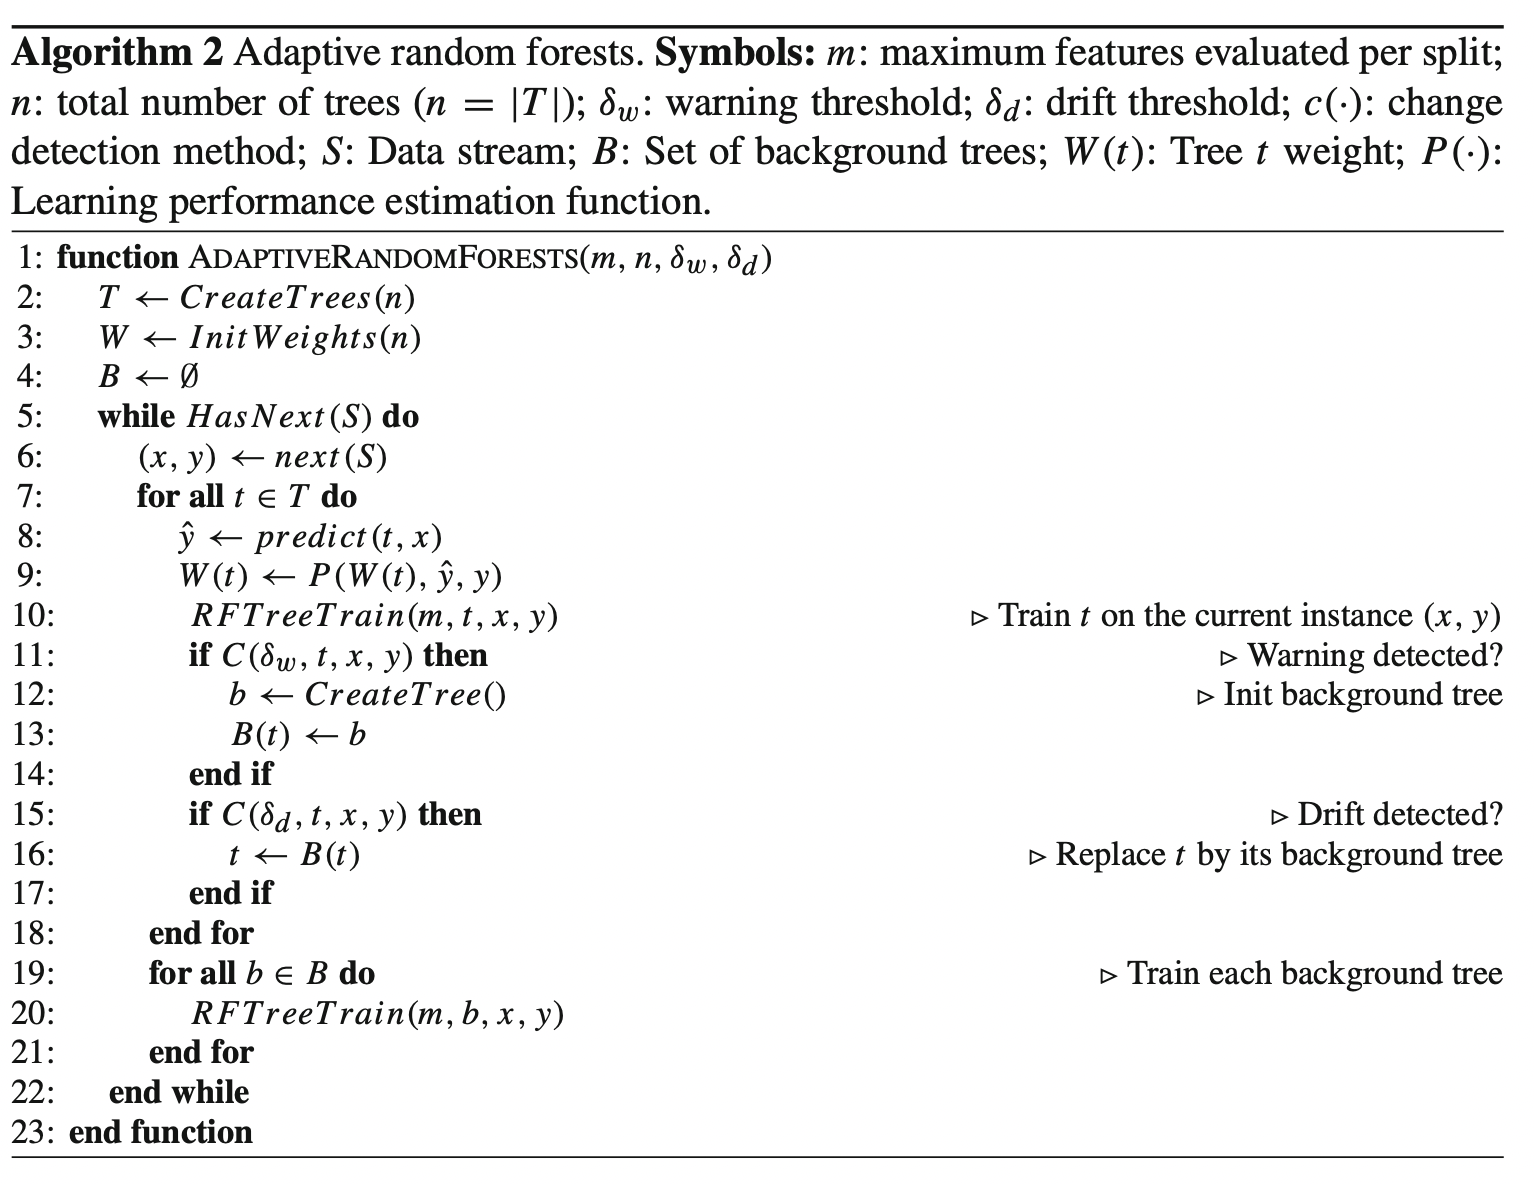

In [ ]:

from IPython.display import Image
Image(filename='/Users/cameronlooney/Desktop/Screenshot 2022-11-18 at 13.46.21.png') 

Adaptive Random Forests (ARF) are a new Random forests algorithm for evolving datastream classification. As shown in [[paper](https://link.springer.com/content/pdf/10.1007/s10994-017-5642-8.pdf)], ARF is able to obtain high classification in data streams with different characteristics without further hyper- parameter tuning. Since it is a sustainable off-the-shelf learner for the challenging task of evolving data stream classification, it is going to be useful for both practical applications and as a benchmark for future algorithms proposals in the field.

In data stream learning it is infeasible to perform multiple passes over input data. Thus, an adaptation of Random Forests to streaming data depends on: <br>
- 1. an appropriate online bootstrap aggregating process; and 
- 2. limiting each leaf split decision to a subset of features. 

The second requirement is achieved by modifying the base tree induction algorithm, effectively by restricting the set of features considered for further splits to a random subset of size m, where m < M and M corresponds to the total number of features.

The model also employes the use of the ADWIN drift detection method. [[paper](https://epubs.siam.org/doi/abs/10.1137/1.9781611972771.42)] 

**ADWIN (ADaptive WINdowing)** is a popular drift detection method with mathematical guarantees. ADWIN efficiently keeps a variable-length window of recent items; such that it holds that there has no been change in the data distribution. This window is further divided into two sub-windows $(W_0, W_1)$ used to determine if a change has happened. ADWIN compares the average of $W_0$ and $W_1$ to confirm that they correspond to the same distribution. Concept drift is detected if the distribution equality no longer holds. Upon detecting a drift, $W_0$ is replaced by $W_1$ and a new $W_1$ is initialised. ADWIN uses a significance value $\delta \in (0,1)$ to determine if the two sub-windows correspond to the same distribution.

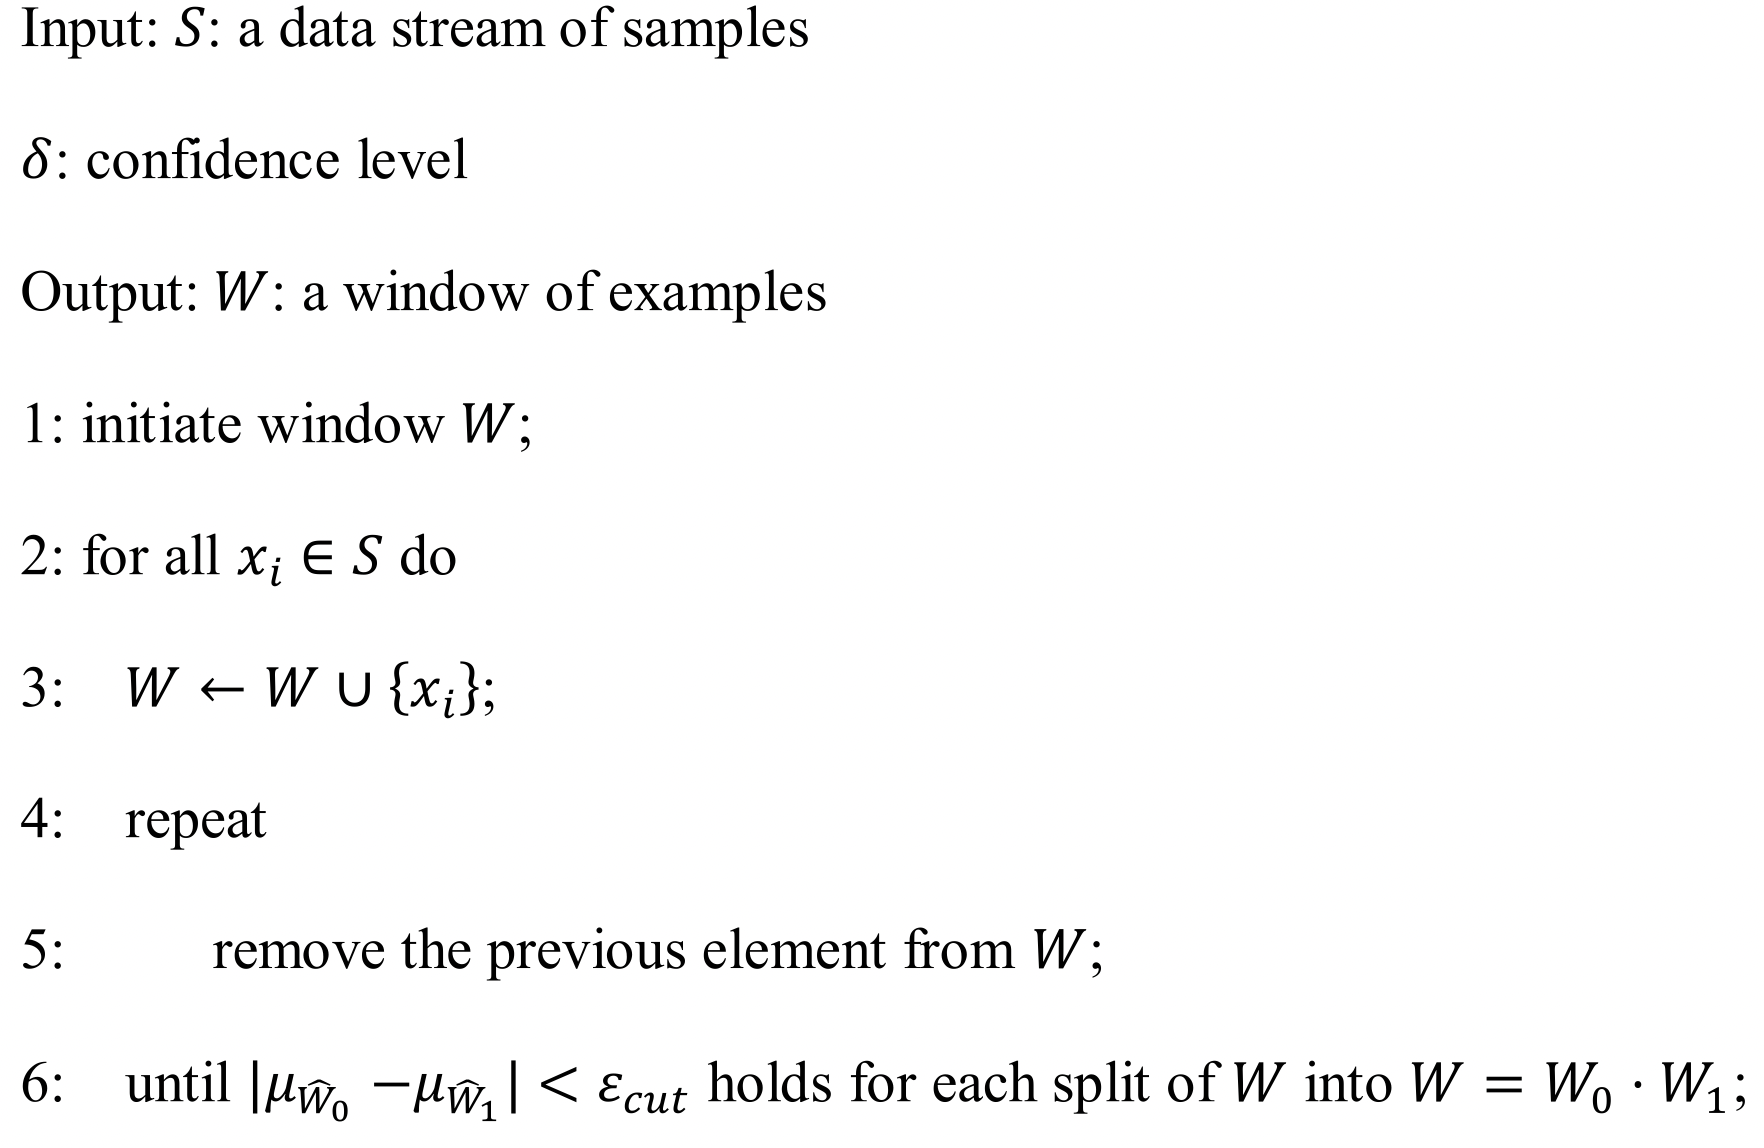

In [ ]:
Image(filename='/Users/cameronlooney/Desktop/Screenshot 2022-11-18 at 13.56.12.png') 

### Model 2: ARF-DDM

The second model utilises the same ARF framework, however it is combined with the Drift Detection Method Alorgorithm

**Drift Detection Method.**

DDM (Drift Detection Method) [[paper](https://www.semanticscholar.org/paper/Learning-with-Drift-Detection-Gama-Medas/3cb54f04765c19e7e0580196c29c64e49f63a744)] is a concept change detection method based on the PAC learning model premise, that the learner's error rate will decrease as the number of analysed samples increase, as long as the data distribution is stationary.

If the algorithm detects an increase in the error rate, that surpasses a calculated threshold, either change is detected or the algorithm will warn the user that change may occur in the near future, which is called the warning zone.

The detection threshold is calculated in function of two statistics, obtained when $(p_i + s_i)$ is minimum .

- $p_{min}$: The minimum recorded error rate.
- $s_{min}$: The minimum recorded s.d.

At index i the algorithm uses:

- $p_{i}$: The error rate at index i.
- $s_{i}$: The s.d at index i

The conditions for entering the warning zone and detecting change are as follows;
- if $p_{i} + s_{i} \ge p_{min} + w*s_{min}$
- if $p_{i} + s_{i} \ge p_{min} + d*s_{min}$

where
- $w$ = warning threshold
- $d$ = drift threshold

### Model 3: HT - ADWIN

A Hoeffding Tree is an incremental, anytime decision tree induction algorithm that is capable of learning from massive data streams, assuming that the distribution generating examples does not change over time. Hoeffding trees exploit the fact that a small sample can often be enough to choose an optimal splitting attribute. This idea is supported mathematically by the Hoeffding bound, which quantifies the number of observations needed to estimate some statistics within a prescribed precision.

A theoretically appealing feature of Hoeffding Trees not shared by other incremental decision tree learners is that it has sound guarantees of performance. Using the Hoeffding bound one can show that its output is asymptotically nearly identical to that of a non-incremental learner using infinitely many example. 


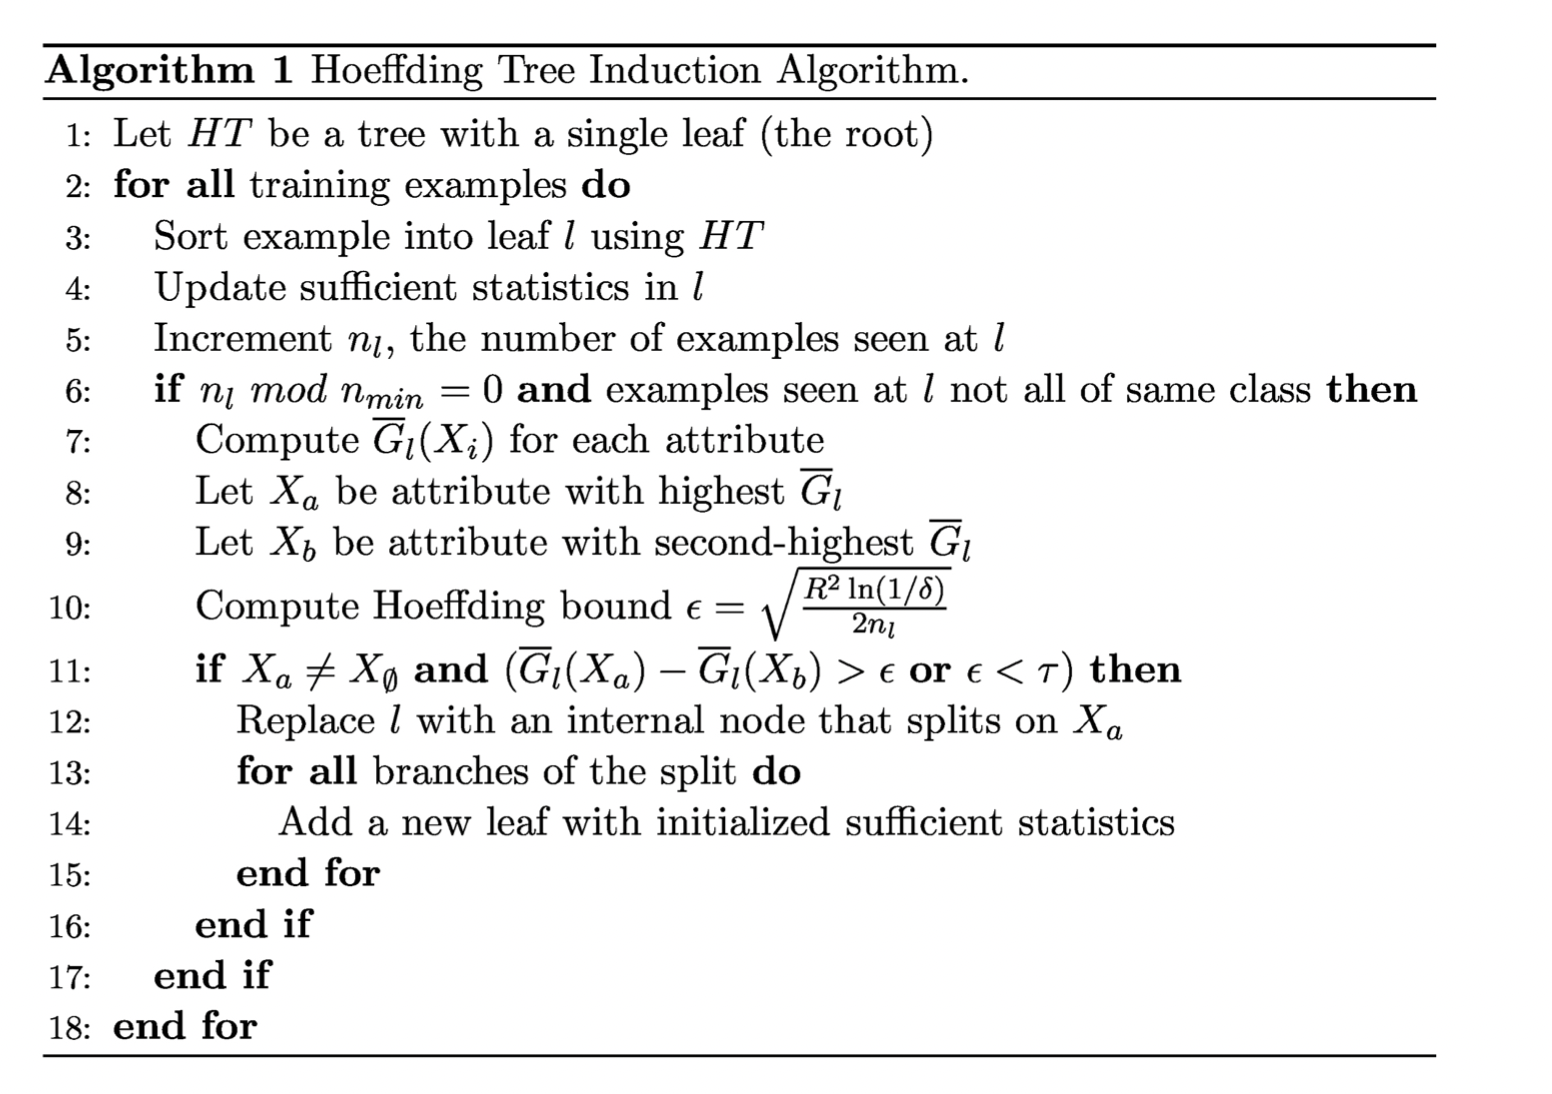

In [ ]:
Image(filename='/Users/cameronlooney/Desktop/Screenshot 2022-11-18 at 14.12.50.png') 

# Offline LightGBM Approx Interpretation

The offline segment of the framework works as follows
1. Get 2nd and 3rd quantiles of attack run  - Due to attack happening over time we can generalise 
2. Compare indices of attack run with indices of online LightGBM retrains
3. Fit the model from retrain point + look back window : to start of attack run
4. Predict attack run indices
5. Generate anchors for each point in run 
6. Aggregate the prevalency of components in anchors
7. Return most likely components

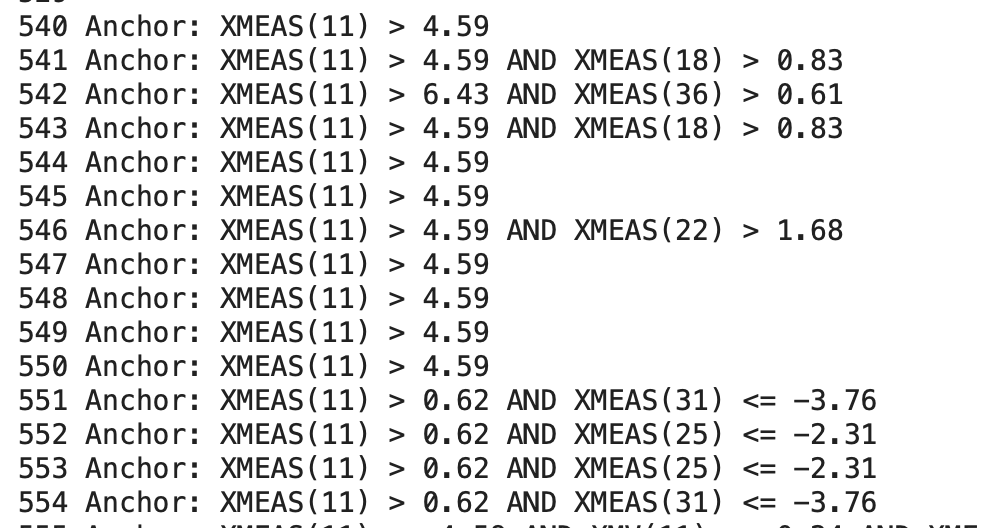

In [ ]:
Image(filename='/Users/cameronlooney/Desktop/Screenshot 2022-11-18 at 14.21.01.png')

In the example above we attacked `Water inlet temperature for condenser cooling` which is attack `IDV(5)` and the model returned `XMEAS(11)` which refers to the Product Sep Temp (◦ C)

## Anchors Explained

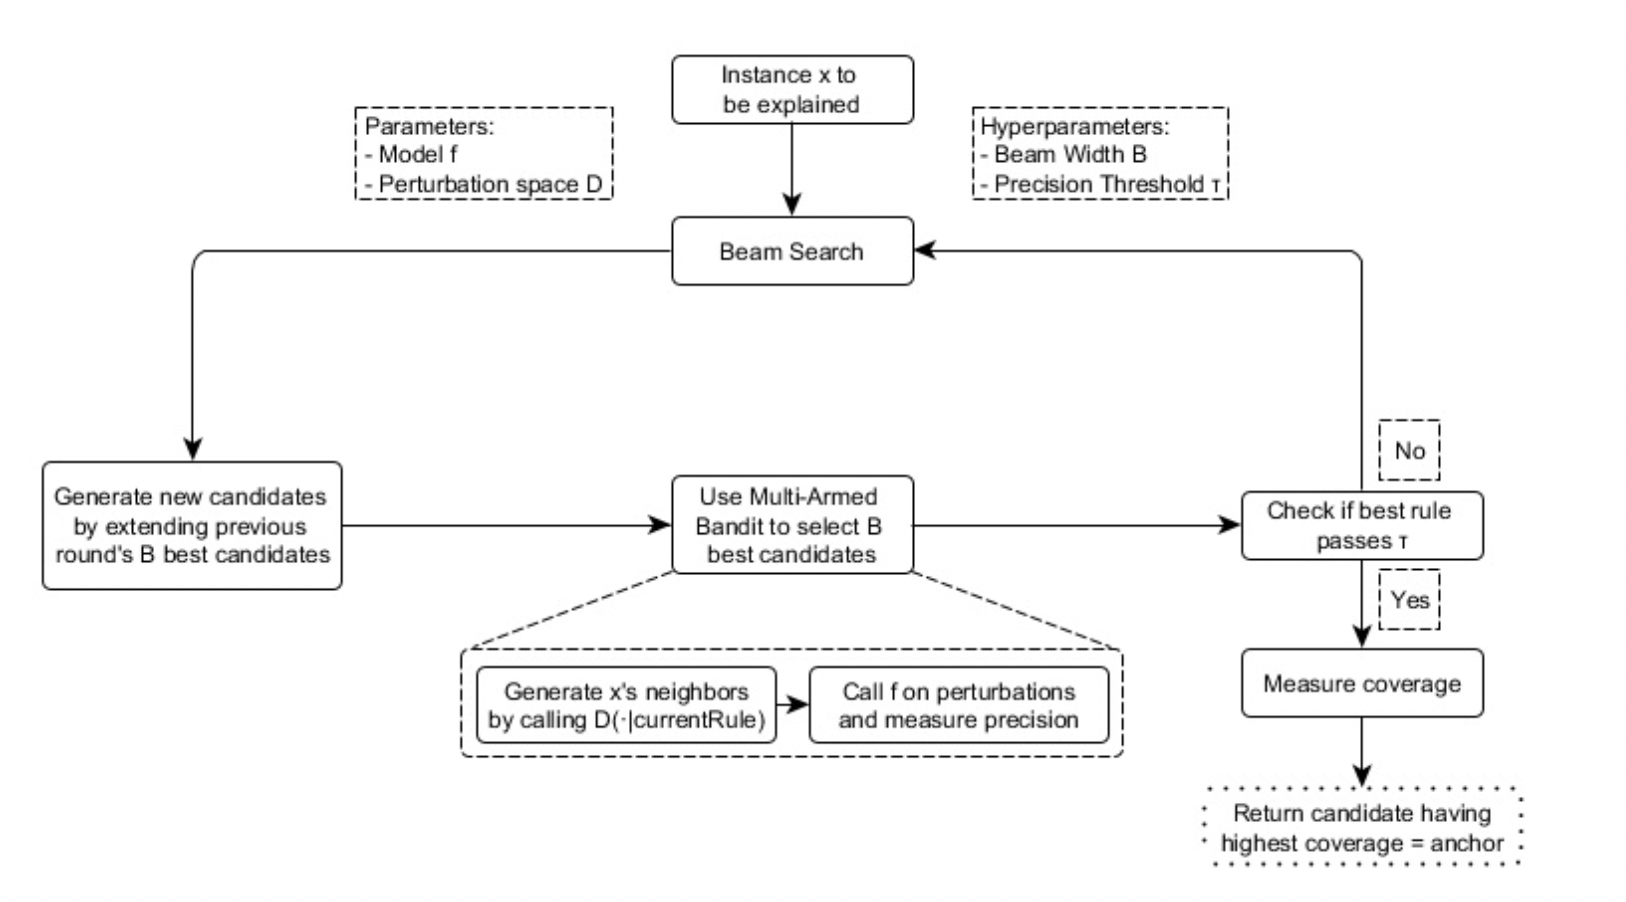

In [ ]:
Image(filename='/Users/cameronlooney/Desktop/Screenshot 2022-11-18 at 14.45.56.png')

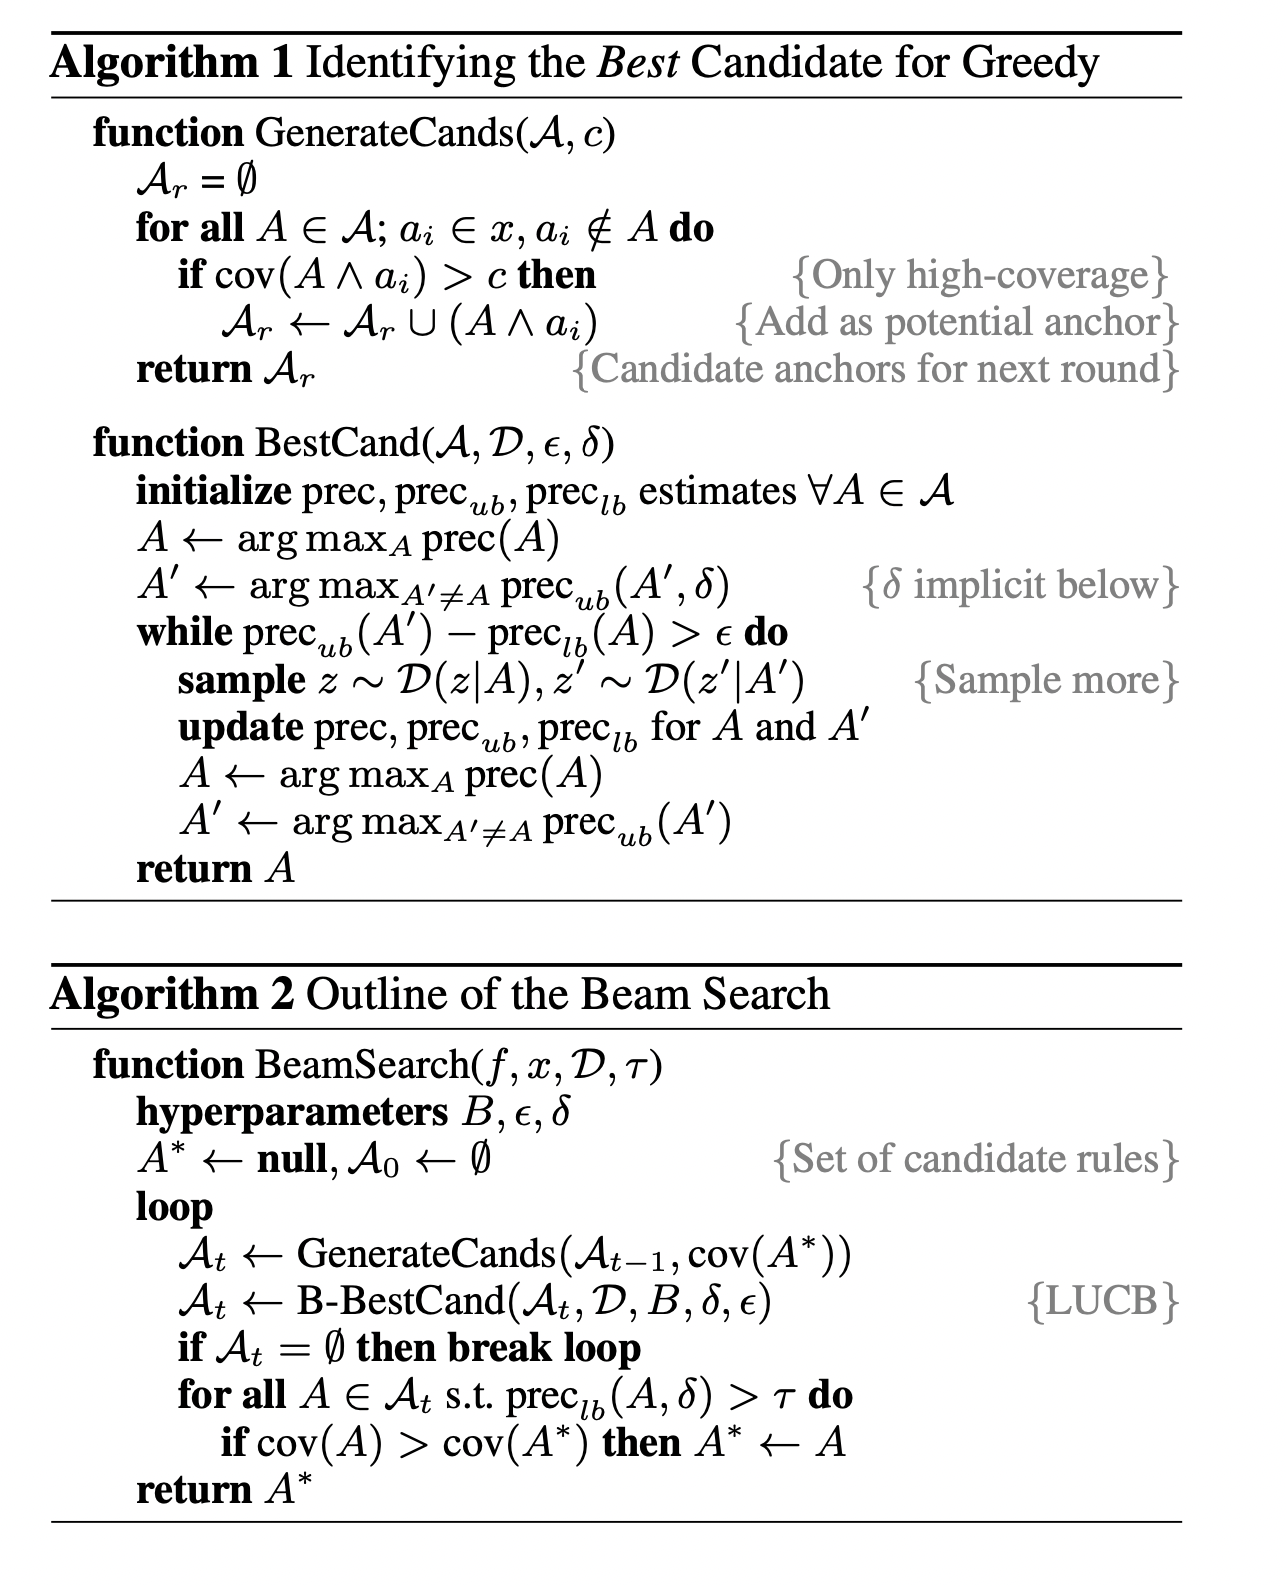

In [ ]:
Image(filename='/Users/cameronlooney/Desktop/Screenshot 2022-11-18 at 14.47.52.png')

### **Definition of an Anchor**
Given an instance $x$ to be explained, a rule or an anchor $A$ is to be found, such that it applies to $x$, while the same class as for $x$ gets predicted for a fraction of at least $\tau$ of $x$'s neighbours where the same $A$ is applicable. A rule’s precision results from evaluating neighbors or perturbations (following $D_x(z|A)$) using the provided machine learning model (denoted by the indicator function $1_{\hat{f}(x)=\hat{f}(z)}$


The anchors method explains individual predictions of any black box classification model by finding a decision rule that “anchors” the prediction sufficiently. A rule anchors a prediction if changes in other feature values do not affect the prediction. Anchors utilizes reinforcement learning techniques in combination with a graph search algorithm to reduce the number of model calls (and hence the required runtime) to a minimum while still being able to recover from local optima.

The anchors approach deploys a **perturbation-based** strategy to generate local explanations for predictions of black box machine learning models. The resulting explanations are expressed as easy-to-understand IF-THEN rules, called anchors. These rules are reusable, since they are **scoped**: anchors include the notion of **coverage**, stating precisely to which other, possibly unseen, instances they apply. Finding anchors involves a multi-armed bandit problem. To this end, neighbors, or **perturbations**, are created and evaluated for every instance that is being explained. Doing so allows the approach to disregard the black box’s structure and its internal parameters so that these can remain both unobserved and unaltered. Thus, the algorithm is **model-agnostic**, meaning it can be applied to any class of model.

**Example from paper**
IF `SEX = female` AND `Class = first` THEN PREDICT `Survived = true` WITH <br> PRECISION 97% <br> COVERAGE 15%

The example shows how anchors can provide essential insights into a model’s prediction and its underlying reasoning. The result shows **which attributes were taken into account** by the model, which in this case, is the female sex and first class. Humans, being paramount for correctness, can use this rule to validate the model’s behavior. The anchor additionally tells us that it applies to 15% of perturbation space’s instances. In those cases the explanation is 97% accurate, meaning the displayed predicates are almost exclusively responsible for the predicted outcome.

Thus, anchors lend themselves well to our use case of localising the attack. The logic being, if from our online model we predict that an instance is an attack, if we apply a model and look at which attributes anchor the prediction, we will hope to see where the attack is occuring. While this may not be accurate on one instance as we are using 2 seperate models for predicting and interpreting, if we aggregate the anchors across the entire attack run , the generalisation will help increase confidence in the results


#### **References for Anchor** 
[Molnar, C. (2022). Interpretable Machine Learning:
A Guide for Making Black Box Models Explainable (2nd ed.)](https://christophm.github.io/interpretable-ml-book/intro.html) - Great overview of anchor

[Explainable Artificial Intelligence: a Systematic Review](https://arxiv.org/pdf/2006.00093.pdf)

[Information Compexity in Bandit Subset Selection](https://www.cse.iitb.ac.in/~shivaram/papers/kk_colt_2013.pdf)

[Anchors: High-Precision Model-Agnostic Explanations](https://homes.cs.washington.edu/~marcotcr/aaai18.pdf)

[Alibi Explain: Algorithms for Explaining Machine Learning Models](https://jmlr.org/papers/v22/21-0017.html)

In [ ]:
from colab_pdf import colab_pdf
colab_pdf('PWATE.ipynb')